In [2]:
import tsfresh as tsf
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns

from importlib import reload
from datetime import timedelta
from scipy import signal
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from tsfresh.utilities.distribution import ClusterDaskDistributor
from src import main, feature_model, extract_tsf_features_by_window as extract
from dask_jobqueue import SLURMCluster
from distributed import Client, as_completed

# Extract features from data

In [3]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', cores=2, memory='4gb', walltime='3:00:00', death_timeout=60)
    client = Client(cluster)
    cluster.adapt(minimum=1, maximum=100)

In [21]:
client

Client Scheduler: tcp://10.120.16.230:52332 Dashboard: http://10.120.16.230:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
cis_colnames = {'t_colname': 'Timestamp', 'xyz_colnames': ['X', 'Y', 'Z']}
smartwatch_colnames = {'devid_colnames': ['device_id']}

In [5]:
def extract_tsf_features(input_fp, 
                         window_offset=5, 
                         window_size=10, 
                         samp_rate='100ms',
                         rms_g_constant=1,
                         colnames=dict()):
    seq = main.read_seq(input_fp, use_time_index=True, resample=samp_rate, **colnames)
    # some slight interpolation for missing values
    seq = seq.interpolate(axis=0, limit=1, method='linear')
    
    # subtract constant for gravity
    rms = pd.DataFrame({'rms': np.sqrt(np.square(seq).sum(axis=1, skipna=False)) - rms_g_constant})
    
    window_starts = [pd.Timedelta(seconds=t) for t in [*range(0, rms.index.get_level_values('t').max().seconds - window_size, window_offset)]]
    samples = main.sample_seq(rms, starts=window_starts, samp_len=pd.Timedelta(seconds=window_size), reset_time=True)
    for i, df in enumerate(samples):
        df['ord'] = str(i)
        if 'devid_colnames' in colnames:
            df.reset_index(level=colnames['devid_colnames'], inplace=True)
            df['ord'] += '-' + df[colnames['devid_colnames'][0]]
            df.drop(columns=colnames['devid_colnames'], inplace=True)
    
    # remove windows with nulls
    tsf_data = pd.concat(samples, axis=0).groupby('ord').filter(lambda x: x.notnull().values.all())
    
    tsf_df = tsf.extract_features(tsf_data, column_id="ord", disable_progressbar=True, n_jobs=0)
    samp_id = os.path.splitext(os.path.basename(input_fp))[0]
    tsf_df['samp_id'] = samp_id

    return tsf_df

In [6]:
window_size = 10
window_offset = 5
futures = []

In [33]:
# Training data for cis_pd
fps = glob.glob('data/cis-pd/training_data/*.csv')
futures = client.map(extract_tsf_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=1, 
                          colnames=cis_colnames)

In [7]:
# real_pd smartphone accelerometer
fps = glob.glob('data/real-pd/training_data/smartphone_accelerometer/*.csv')
futures = client.map(extract_tsf_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=9.81)

In [13]:
# real_pd smartwatch accelerometer
fps = glob.glob('data/real-pd/training_data/smartwatch_accelerometer/*.csv')
futures = client.map(extract_tsf_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=9.81, 
                          colnames=smartwatch_colnames)

In [27]:
# real_pd smartwatch gyroscope
fps = glob.glob('data/real-pd/training_data/smartwatch_gyroscope/*.csv')
futures = client.map(extract_tsf_features, fps, 
                          window_size=window_size, 
                          window_offset=window_offset, 
                          rms_g_constant=0, 
                          colnames=smartwatch_colnames)

In [35]:
# Write to disk directly since too much to store in mem
iterator = as_completed(futures)
future = next(iterator)
while future.status == 'error': 
    future = next(iterator)
result = future.result()
result.to_csv('extracted_features/cis-tsfeatures.csv', header=True)

# Write remaining dfs in append mode 
for future in tqdm(iterator, total=len(futures)-1):
    if future.status == 'finished':
        result = future.result()
        result.to_csv('extracted_features/cis-tsfeatures.csv', header=False, mode='a')

# PCA on windowed tsfresh features

In [3]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', cores=8, memory='8gb', walltime='1:00:00', death_timeout=60)
    client = Client(cluster)
    cluster.adapt(minimum=1, maximum=100)

## Yidi's windows

In [5]:
features = pd.read_csv('extracted_features/cis-tsfeatures.csv', skiprows=lambda i: not i%8 == 0)

In [6]:
label_cols = ['on_off', 'dyskinesia', 'tremor', 'subject_id']
other_cols = ['samp_id']
labels = pd.read_csv('/home/hy180/projects/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv', index_col=0)

In [69]:
drop_cols = ['rms__friedrich_coefficients__m_3__r_30__coeff_0',
       'rms__friedrich_coefficients__m_3__r_30__coeff_1',
       'rms__friedrich_coefficients__m_3__r_30__coeff_2',
       'rms__friedrich_coefficients__m_3__r_30__coeff_3',
       'rms__max_langevin_fixed_point__m_3__r_30']
df = labels.merge(features.drop(columns=drop_cols), left_index=True, right_on='samp_id')

In [76]:
df.dropna(axis='columns', thresh=0).isnull().sum(axis=1).value_counts()

196    27424
197    18279
198     7363
225      142
226       87
199       21
227       10
228        8
202        1
dtype: int64

In [73]:
# TODO: why are some features failing on small numbers of samples? 
features.isnull().sum(axis=0).value_counts()

0        526
53335    196
247       24
903        5
248        5
dtype: int64

In [49]:
df = df.dropna(axis='columns', thresh=500).dropna(axis='rows')

In [97]:
from sklearn import decomposition
import umap

label = 'tremor'
X = df[df.samp_id.isin(df.dropna(subset=[label]).samp_id)].drop(columns=[*label_cols, *other_cols]).dropna(axis='columns')
y = df[df.samp_id.isin(df.dropna(subset=[label]).samp_id)][[*label_cols, *other_cols]]

# ca = decomposition.PCA()
ca = umap.UMAP(n_components=5)

tornado.application - ERROR - Uncaught exception GET /graph/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:8787', method='GET', uri='/graph/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/home/hy180/anaconda3/lib/python3.7/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/hy180/anaconda3/lib/python3.7/site-packages/bokeh/server/views/ws.py", line 135, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [98]:
fut = client.submit(ca.fit_transform, X)

In [99]:
fut

<Future: pending, key: fit_transform-bbdfdadae4d8314180ac97568c4e82aa>

In [81]:
fut.result()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [39]:
proj = client.gather(fut)

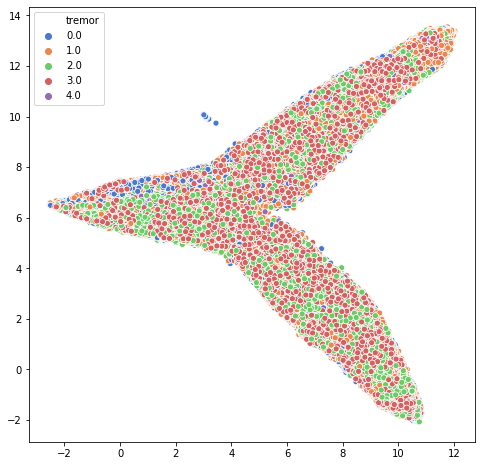

In [42]:
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=y.loc[:, 'tremor'], legend='full', palette="muted")

In [96]:
labels[labels.subject_id==1048].on_off.value_counts()

2.0    45
1.0    27
3.0    14
4.0     3
0.0     2
Name: on_off, dtype: int64

In [92]:
labels[labels.tremor==4]

,subject_id,on_off,dyskinesia,tremor
measurement_id,,,,
daf11494-e6fa-4376-a78a-86c683885764,1004,4.0,4.0,4.0
ee389c0c-71dd-47a9-9249-9c1bcd6c4f69,1048,1.0,3.0,4.0
eef56825-940a-4c3e-aebb-60838d60869e,1048,4.0,3.0,4.0
40f713fe-0ac9-4cd0-809c-0a8024955a2a,1048,3.0,3.0,4.0
4913062f-b696-40c6-a0f2-87efe1dd4810,1048,3.0,3.0,4.0
b9ada852-4ff5-4ee1-8529-96a79ced0610,1048,1.0,4.0,4.0
7b2698a6-f3a5-4345-9630-25d377d58992,1048,2.0,3.0,4.0
dd140d80-bcab-458b-bd0e-82cd584d0f28,1048,3.0,3.0,4.0
e0441156-c4b8-467c-8f4f-3b532d594d8f,1048,4.0,3.0,4.0


## Mark's windows

In [ ]:
raise Exception

In [4]:
import glob
import os

In [7]:
def read_samps(fp):
    df = pd.read_csv(fp, index_col=0)
    df = df.rename(columns={'id': 'axis'})    
    df['samp_id'] = os.path.splitext(os.path.splitext(os.path.basename(fp))[0])[0]
    return df[df.axis=='X']

In [8]:
futures = client.map(read_samps, glob.glob('/home/mk596/research/beat_pd/data/cis-pd/training_data_tsf/*.tsf.csv')[:300])

In [17]:
dfs = client.gather(futures)
features = pd.concat(dfs)

In [9]:
dfs = []
for fp in tqdm(glob.glob('/home/mk596/research/beat_pd/data/cis-pd/training_data_tsf/*.tsf.csv')[:300]):
    df = pd.read_csv(fp, index_col=0)
    df = df.rename(columns={'id': 'axis'})    
    df['samp_id'] = os.path.splitext(os.path.splitext(os.path.basename(fp))[0])[0]
    dfs.append(df[df.axis=='X'])
    
features = pd.concat(dfs)